## Matcha Litteraturbanken personer utan bild i WD med SPA
Nedan test att hitta kandidater som saknar bild och är kopplade till Litteratur banken men saknar bild

Version   
* 0.1 skriver bara ut vid träff och över 30

* denna [Notebook](https://github.com/salgo60/spa2Commons/blob/main/Notebook/Litteraturbanken%20SPA.ipynb)
  * [Notebook leta bilder SPA](https://github.com/salgo60/spa2Commons/blob/main/Notebook/Litteraturbanken%20SPA.ipynb)
  * [Notebook för att matcha med WIkidata](https://github.com/salgo60/spa2Commons/blob/main/Notebook/Litteraturbanken%20SPA.ipynb)
* [video](https://youtu.be/j8Pe-7E4pT0)
  * se även [GITHUB SPA2Common](https://github.com/salgo60/spa2Commons) / [video](https://www.youtube.com/watch?v=B3moN36PsNo)
  * [Notebook samma som Litteraturbanken LIBRISXL](https://github.com/salgo60/spa2Commons/blob/main/Notebook/Litteraturbanken%20-%20samma%20som.ipynb)
  
  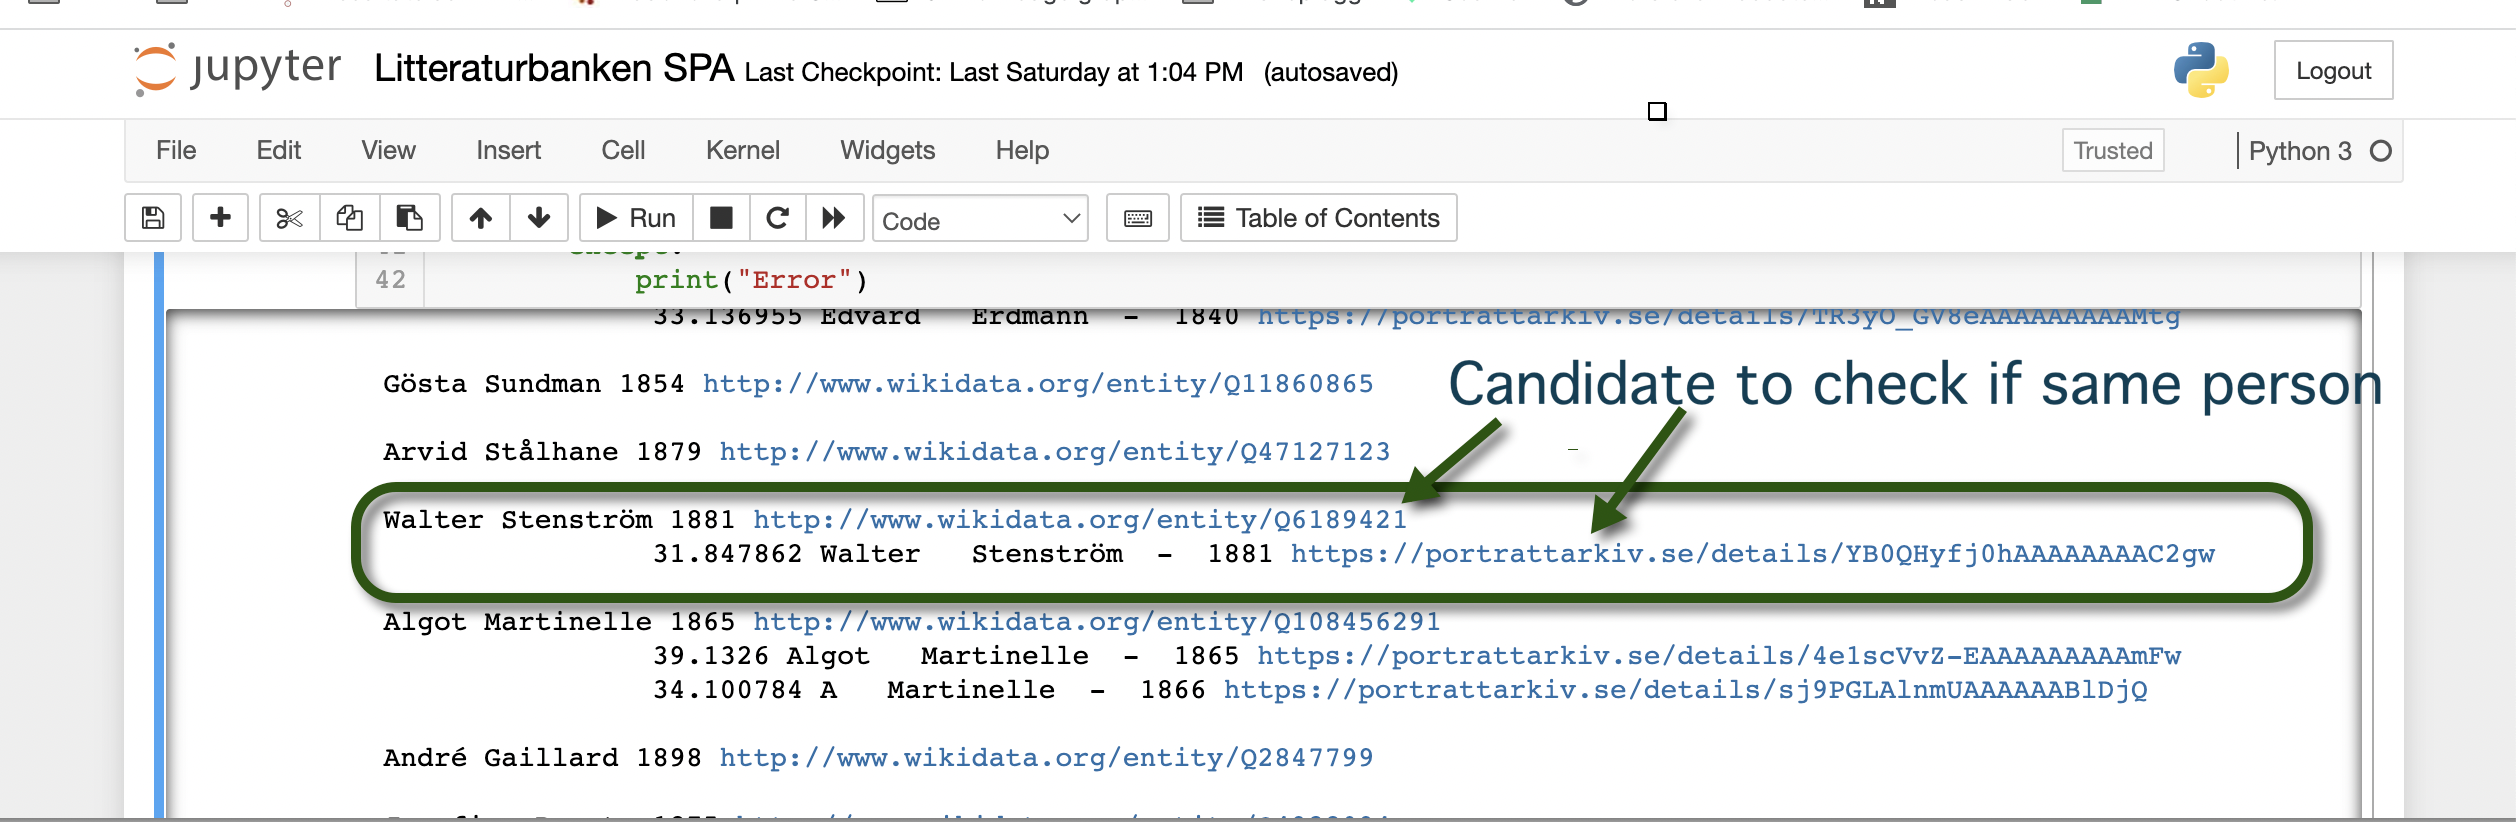

In [6]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)


Last run:  2023-01-03 10:43:12.919072


In [2]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import pandas as pd
import sys,json
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

#https://w.wiki/4J4B
queryLittNoPic = """SELECT ?item ?itemLabel (year(?born) as ?year) ?statements ?Litteraturbankenid
 (CONCAT(?itemLabel," ",str(year(?born))) AS ?search) WHERE {
   ?item wdt:P5101 ?Litteraturbankenid ;
         wikibase:statements ?statements .
 # FILTER (?statements <100)
  minus {?item wdt:P18 ?img}
  OPTIONAL{?item wdt:P569 ?born}
  FILTER (year(?born) < 1900)
  FILTER (year(?born) > 1800)
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}  order by desc(?statements)
"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, queryLittNoPic)


def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDLittNoPic = get_sparql_dataframe(endpoint_url, queryLittNoPic)
WDLittNoPic.shape

(395, 6)

In [3]:
WDLittNoPic

item            itemLabel  year  \
0      http://www.wikidata.org/entity/Q1787190      Mathilde Prager  1844   
1     http://www.wikidata.org/entity/Q20652547       Franz Hoffmann  1814   
2      http://www.wikidata.org/entity/Q1744240         Laura Kieler  1849   
3      http://www.wikidata.org/entity/Q3121041  Gustaf Nordenskiöld  1868   
4       http://www.wikidata.org/entity/Q389396      Johan Andersson  1820   
..                                         ...                  ...   ...   
390   http://www.wikidata.org/entity/Q52577083    Gunnar Wetterberg  1863   
391   http://www.wikidata.org/entity/Q52690406       J.E. Ahlstrand  1814   
392  http://www.wikidata.org/entity/Q114115033        Josef Jonsson  1850   
393  http://www.wikidata.org/entity/Q115958630           Q115958630  1867   
394  http://www.wikidata.org/entity/Q100322150         M. L. Sunder  1840   

    statements Litteraturbankenid                    search  
0           66          HolmErich      Mathilde Prager 1844  
1           55          HoffmannF       Franz Hoffmann 1814  
2           48            KielerL         Laura Kieler 1849  
3           48      NordenskiöldG  Gustaf Nordenskiöld 1868  
4           46     AnderssonJohan      Johan Andersson 1820  
..         ...                ...                       ...  
390          5        WetterbergG    Gunnar Wetterberg 1863  
391          5        AhlstrandJE       J.E. Ahlstrand 1814  
392          5           JonssonJ        Josef Jonsson 1850  
393          4       SalomonssonS           Q115958630 1867  
394          3           SunderML         M. L. Sunder 1840  

[395 rows x 6 columns]

In [9]:
import urllib3, json
http = urllib3.PoolManager() 
SPAdetail = "https://portrattarkiv.se/details/"
url= "https://portrattarkiv.se/endpoints/search.php"  
urlbasePic = "https://portrattarkiv.se/endpoints/file.php?id="


for index, row  in WDLittNoPic.iterrows():
    #print("\n",row["search"],row["item"])
    encoded_body = json.dumps({
        "limit": "5",
        "from": "0",
        "birthyear":row["year"],
        "all":row["search"]
    })
    firstHeader = True # track header 
    
    r = http.request('POST', url,
                 headers={'Content-Type': 'application/json'},
                 body=encoded_body)

    if r.status != 200:
        print(r.status)
        continue
    
    data = json.loads(r.data.decode('utf-8'),) 
    urls = []


    for h in data["hits"]["hits"]:
        id = h["_id"]
        #print(h)
        source = h["_source"]
        try:
            urlPicture = urlbasePic + id
#            urls.append(urlPicture)
            score = h["_score"]
            FirstName = source["FirstName"]
            LastName = source["LastName"]
            BirthYear = source["BirthYear"]
            if score > 30:
                if firstHeader:
                    print("\n",row["search"],row["item"])
                    firstHeader = False # track header
                print("\t\t",score,FirstName, " ", LastName, " - ", BirthYear,SPAdetail+id, "\t", )
        except:
            print("Error")


 August Zacharias Collin 1833 http://www.wikidata.org/entity/Q5610869
		 34.43135 August   Collin  -  1833 https://portrattarkiv.se/details/sj9PGLAlnmUAAAAAAB2-3g 	

 Carolina von Platen 1816 http://www.wikidata.org/entity/Q16616025
		 33.689552 Achates   von Platen  -  1816 https://portrattarkiv.se/details/sj9PGLAlnmUAAAAAABL9eQ 	

 August Theodor Låstbom 1815 http://www.wikidata.org/entity/Q4820829
		 37.157772 August   Låstbom  -  1815 https://portrattarkiv.se/details/WQknIBFpuuAAAAAAAAN75w 	

 Carl Magnus Stenbock 1874 http://www.wikidata.org/entity/Q52508735
		 33.440323 Vilfrid   Stenbock  -  1874 https://portrattarkiv.se/details/4e1scVvZ-EAAAAAAAAAryQ 	

 Johan G. R. Banér 1862 http://www.wikidata.org/entity/Q94538588
		 36.18424 Johan   Banér-Runeskiöld  -  1862 https://portrattarkiv.se/details/sj9PGLAlnmUAAAAAABfoqQ 	

 Per Adolf Hagström 1823 http://www.wikidata.org/entity/Q108817417
		 30.209373 Per   Hagström  -  1823 https://portrattarkiv.se/details/j6S8rJvx9lAAAAAAAACvdg

In [5]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Ended:  2023-01-03 08:29:44.587496
Time elapsed (hh:mm:ss.ms) 0:00:32.580947
